In [1]:
import matplotlib.pyplot as plt
from aerobot.io import RESULTS_PATH, load_results_dict, DATA_PATH
from aerobot.plot import plot_configure_mpl, plot_color_palette 
import pandas as pd
from matplotlib.gridspec import GridSpec
from scipy.stats import linregress
import numpy as np
import os
from typing import List, Dict, Tuple
%load_ext autoreload 
%autoreload 2 

plot_configure_mpl(figure_height=1)

In [2]:
emp_merged_raw_df = pd.read_csv(os.path.join(DATA_PATH, 'earth_microbiome', 'merged_raw.csv'), index_col=0)
emp_merged_filtered_df = pd.read_csv(os.path.join(DATA_PATH, 'earth_microbiome', 'merged_filtered.csv'), index_col=0)

# emp_merged_filtered_df.head()

# SI Figure 6

In [3]:
def plot_si_figure_6a(emp_merged_raw_df:pd.DataFrame, emp_merged_filtered_df:pd.DataFrame, fig:plt.Figure=None, grid:GridSpec=None):
    
    ax = fig.add_subplot(grid)

    ax.set_xscale('log')

    bins = np.logspace(0, 2, 20)
    # Histogram of the number of each metagenome IDs. 
    ax.hist(emp_merged_raw_df.metagenome_id.value_counts(), bins=bins, color='gray', edgecolor='black', linewidth=0.5, alpha=0.5, label='full dataset')
    ax.hist(emp_merged_filtered_df.metagenome_id.value_counts(), bins=bins, color=plot_color_palette()['blue'], edgecolor='black', linewidth=0.5, label='filtered dataset')

    ax.legend(loc=1)
    ax.set_xlabel('genomes in sample')
    ax.set_ylabel('number of samples')
    ax.set_title('Genomes in samples')

    return ax

In [4]:
def plot_si_figure_6b(emp_merged_filtered_df:pd.DataFrame, fig:plt.Figure=None, grid:GridSpec=None):
    
    ax = fig.add_subplot(grid)
    ax.set_yscale('log')

    # Count up all the labels of MAGS from EMP by habitat
    n_habitats = 10 # Number of habitats to show. 
    habitat_counts = emp_merged_filtered_df.habitat.value_counts().sort_values(ascending=False)[:n_habitats]
    ax.bar(np.arange(n_habitats), habitat_counts.values, facecolor=plot_color_palette()['blue'],  edgecolor='black', linewidth=0.5, )
    ax.set_xticks(np.arange(n_habitats), habitat_counts.index.values, rotation=45, ha='right')
    ax.set_yticks([1e2, 1e3, 1e4])
    ax.set_ylabel('number of genomes')
    ax.set_title('Genomes in habitats')

    return ax
    
    # ax.set_xlabel('habitat')

In [5]:
def plot_si_figure_6c(emp_merged_filtered_df:pd.DataFrame, fig:plt.Figure=None, grid:GridSpec=None):
    
    ax = fig.add_subplot(grid)
    ax.set_yscale('log')
    # Count up all the labels of MAGS from EMP
    pred_counts = emp_merged_filtered_df.prediction.value_counts()

    ax.bar(np.arange(3), pred_counts.values, facecolor=plot_color_palette()['blue'], edgecolor='black', linewidth=0.5, )
    ax.set_xticks(np.arange(3), pred_counts.index.values, rotation=45, ha='right')
    ax.set_title('Predicted O$_2$ usage')
    ax.set_ylabel('number of genomes')

    return ax


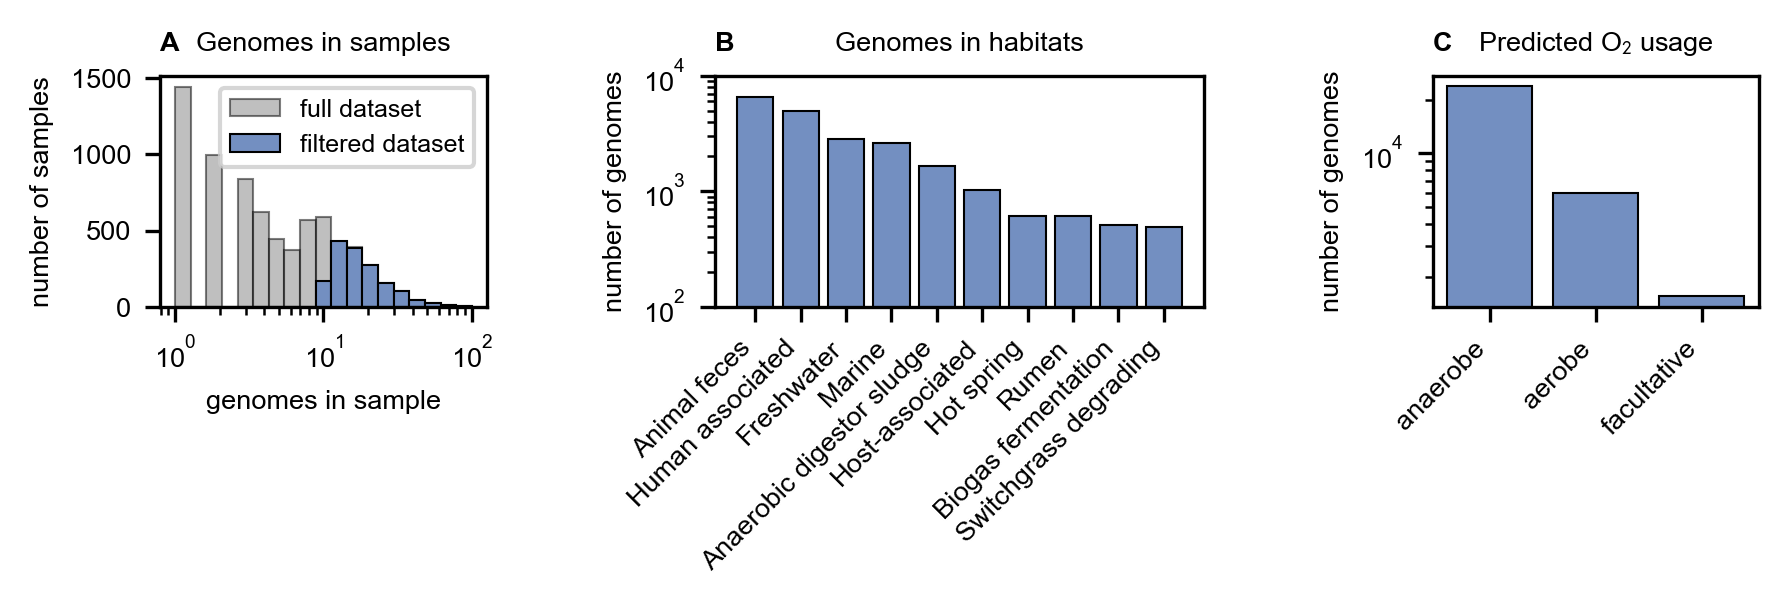

In [6]:
fig = plt.figure()
grid = GridSpec(1, 3, wspace=0.6, width_ratios=[1, 1.5, 1]) 

axes = []
axes.append(plot_si_figure_6a(emp_merged_raw_df, emp_merged_filtered_df, grid=grid[0, 0], fig=fig))
axes.append(plot_si_figure_6b(emp_merged_filtered_df, grid=grid[0, 1], fig=fig))
axes.append(plot_si_figure_6c(emp_merged_filtered_df, grid=grid[0, 2], fig=fig))

for ax, ax_label in zip(axes, 'ABC'):
    ax.set_title(ax_label, loc='left', fontweight='bold')

plt.savefig('../results/figures/si_fig6.png', dpi=300, facecolor='w', bbox_inches='tight')
plt.show()
